In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, box
import datetime as dt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV

In [2]:
nodes = pd.read_csv("node_data.csv")
edges = pd.read_csv("edges_data.csv")
df_2020 = pd.read_csv("data/scats_detector_volume_jan-jun-2020.csv")
sites = pd.read_csv("data/its_scats_sites_aug-2020.csv")
columns_to_load = ["End_Time", "Site", "Detector", "Sum_Volume", "Avg_Volume"]
March2025 = pd.read_csv("data/SCATSMarch2025.csv", usecols=columns_to_load)
April2025 = pd.read_csv("data/SCATSApril2025.csv", usecols=columns_to_load)
May2025 = pd.read_csv("data/SCATSMay2025.csv", usecols=columns_to_load)

In [3]:
df  = pd.concat([March2025, April2025], ignore_index=True)
geo_edges=edges.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_edges['geometry'] = edges['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_edges = gpd.GeoDataFrame(geo_edges, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_edges.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_edges))
geo_nodes=nodes.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_nodes['geometry'] = nodes['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_nodes = gpd.GeoDataFrame(geo_nodes, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_nodes.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_nodes))
sites = sites[~((sites["Lat"] == 0) | (sites["Long"] == 0))]
geo_sites = gpd.GeoDataFrame(
    sites,
    geometry=gpd.points_from_xy(sites['Long'], sites['Lat']),
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)
# Get bounding box of all points
minx, miny, maxx, maxy = geo_edges.total_bounds

# Define grid size (in the CRS units, e.g., degrees if EPSG:4326)
nx = 10  # number of columns
ny = 10  # number of rows
xgrid = np.linspace(minx, maxx, nx+1)
ygrid = np.linspace(miny, maxy, ny+1)

# Create grid polygons
polygons = []
for i in range(nx):
    for j in range(ny):
        polygons.append(box(xgrid[i], ygrid[j], xgrid[i+1], ygrid[j+1]))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=geo_edges.crs)
df_small = df[["End_Time","Site","Detector","Sum_Volume"]]  # only necessary columns
geo_small = geo_sites[['SiteID', 'geometry']]
df_small['Site'] = df_small['Site'].astype('category')
geo_small['SiteID'] = geo_small['SiteID'].astype('category')
gdf = pd.merge(df_small, geo_small, left_on ="Site", right_on = "SiteID", how = "inner")
gdf=gdf.drop("SiteID", axis = 1)
gdf["End_Time"] = pd.to_datetime(gdf["End_Time"], format="%Y%m%d%H%M%S")
gdf = gpd.GeoDataFrame(
    gdf,
    geometry=gdf["geometry"],
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)
gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


C:\Users\smurph61\AppData\Local\Temp\ipykernel_14308\3287620885.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['Site'] = df_small['Site'].astype('category')
C:\Users\smurph61\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,End_Time,Site,Detector,Sum_Volume,geometry
0,2025-03-13 01:00:00,58,6,0,POINT (-6.26523 53.35605)
1,2025-03-13 01:00:00,58,7,5,POINT (-6.26523 53.35605)
2,2025-03-13 01:00:00,58,8,0,POINT (-6.26523 53.35605)
3,2025-03-13 01:00:00,58,9,0,POINT (-6.26523 53.35605)
4,2025-03-13 01:00:00,58,10,0,POINT (-6.26523 53.35605)


In [4]:
# Spatial join points to grid boxes
joined = gpd.sjoin(gdf, grid, how='left', predicate='within')
joined = joined.rename(columns={"index_right": "Grid_ID"})

# Sum Sum_volume per grid cell
grid_sum = joined.groupby('Grid_ID')['Sum_Volume'].sum()

# Assign sums to the grid GeoDataFrame
grid['Sum_volume'] = grid_sum
grid['Sum_volume'] = grid['Sum_volume'].fillna(0)  # fill empty cells
joined.head()

,End_Time,Site,Detector,Sum_Volume,geometry,Grid_ID
0,2025-03-13 01:00:00,58,6,0,POINT (-6.26523 53.35605),45.0
1,2025-03-13 01:00:00,58,7,5,POINT (-6.26523 53.35605),45.0
2,2025-03-13 01:00:00,58,8,0,POINT (-6.26523 53.35605),45.0
3,2025-03-13 01:00:00,58,9,0,POINT (-6.26523 53.35605),45.0
4,2025-03-13 01:00:00,58,10,0,POINT (-6.26523 53.35605),45.0


In [5]:
joined_eval = joined.groupby(["Grid_ID","End_Time"]).agg({
    "Sum_Volume": "sum"
}).reset_index()
joined_eval = joined_eval.sort_values("Grid_ID")
joined_eval.head()

,Grid_ID,End_Time,Sum_Volume
0,3.0,2025-03-01 00:00:00,897
1,3.0,2025-03-01 01:00:00,551
2,3.0,2025-03-01 02:00:00,492
3,3.0,2025-03-01 03:00:00,272
4,3.0,2025-03-01 04:00:00,247


In [18]:
joined_eval["Vol_diff"] = joined_eval["Sum_Volume"].diff().fillna(0)
joined_eval['weekday'] = joined_eval["End_Time"].dt.dayofweek
joined_eval.head()

,Grid_ID,End_Time,Sum_Volume,Vol_diff,weekday
0,3.0,2025-03-01 00:00:00,897,0.0,5
1,3.0,2025-03-01 01:00:00,551,-346.0,5
2,3.0,2025-03-01 02:00:00,492,-59.0,5
3,3.0,2025-03-01 03:00:00,272,-220.0,5
4,3.0,2025-03-01 04:00:00,247,-25.0,5


In [23]:
joined_eval["weekday"].dtype

dtype('int32')

In [39]:
weekdays = joined_eval[joined_eval["weekday"].isin(range(0,5))].copy()
saturdays = joined_eval[joined_eval["weekday"] == 5].copy()
sundays = joined_eval[joined_eval["weekday"] == 6].copy()

In [48]:
grid_id=54
df_weekdays = weekdays[weekdays["Grid_ID"] == grid_id].copy()
df_sat = saturdays[saturdays["Grid_ID"] == grid_id].copy()
df_sun = sundays[sundays["Grid_ID"] == grid_id].copy()

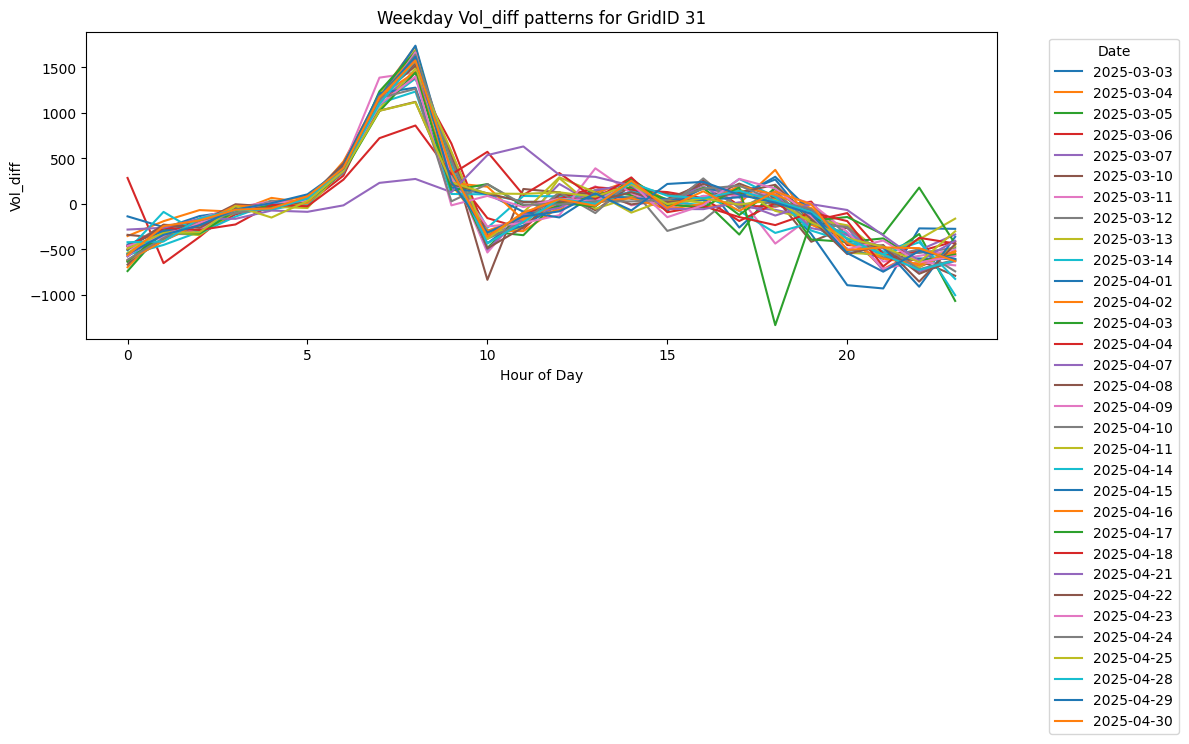

In [ ]:

df_weekdays['date'] = df_weekdays['End_Time'].dt.date
df_weekdays['hour'] = df_weekdays['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_weekdays.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekday Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [34]:

integrals = {}

for date, group in df_weekdays.groupby('date'):
    # Make sure values are sorted in time
    group = group.sort_values('End_Time')
    
    # x = time in hours since start of the day
    x = (group['End_Time'] - group['End_Time'].min()).dt.total_seconds() / 3600
    y = group['Vol_diff'].values
    
    # Trapezoidal integration
    integral = np.trapz(y, x)
    integrals[date] = integral

# Convert to DataFrame
daily_integrals = pd.DataFrame(list(integrals.items()), columns=['date', 'integral'])
print(daily_integrals)


          date  integral
0   2025-03-03     -31.5
1   2025-03-04    1124.5
2   2025-03-05     328.5
3   2025-03-06     771.0
4   2025-03-07     674.5
5   2025-03-10     598.0
6   2025-03-11     481.5
7   2025-03-12     578.0
8   2025-03-13     836.0
9   2025-03-14     -73.5
10  2025-04-01    1037.0
11  2025-04-02     654.5
12  2025-04-03     557.5
13  2025-04-04     930.0
14  2025-04-07     643.0
15  2025-04-08     741.0
16  2025-04-09     743.0
17  2025-04-10     715.5
18  2025-04-11     698.5
19  2025-04-14     611.5
20  2025-04-15     692.0
21  2025-04-16     643.5
22  2025-04-17     506.5
23  2025-04-18     453.5
24  2025-04-21     265.0
25  2025-04-22     489.5
26  2025-04-23     740.5
27  2025-04-24     634.0
28  2025-04-25     640.5
29  2025-04-28     549.0
30  2025-04-29     510.0
31  2025-04-30     987.5


C:\Users\smurph61\AppData\Local\Temp\ipykernel_14308\3977370359.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(y, x)


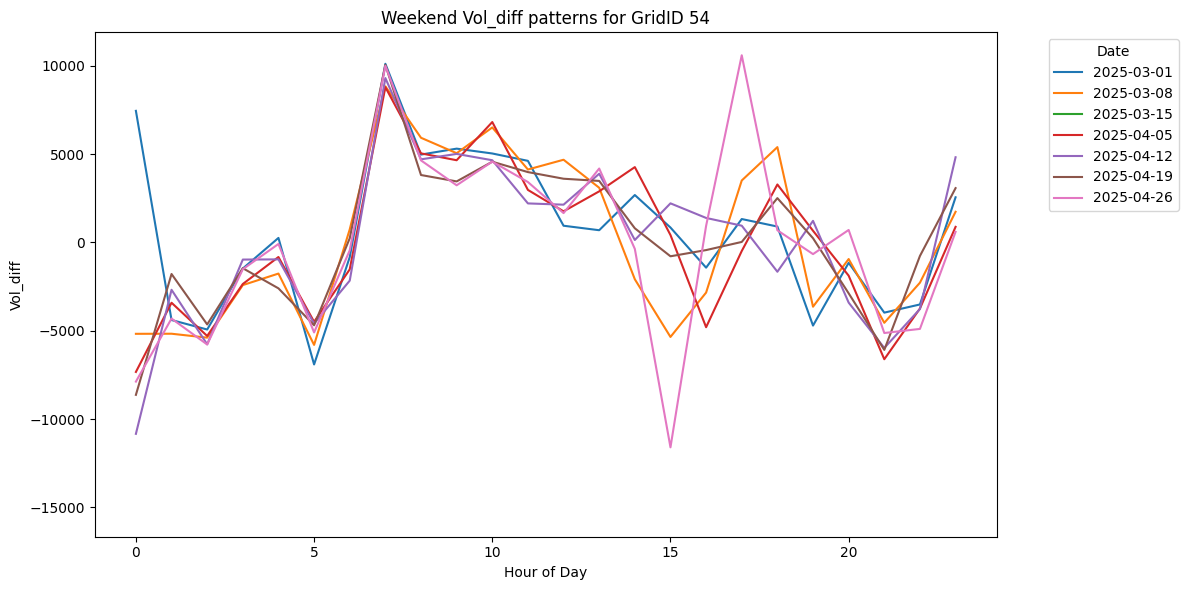

In [ ]:

df_sat['date'] = df_sat['End_Time'].dt.date
df_sat['hour'] = df_sat['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_sat.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekend Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [41]:
integrals_sat = {}

for date, group in df_sat.groupby('date'):
    # Make sure values are sorted in time
    group = group.sort_values('End_Time')
    
    # x = time in hours since start of the day
    x = (group['End_Time'] - group['End_Time'].min()).dt.total_seconds() / 3600
    y = group['Vol_diff'].values
    
    # Trapezoidal integration
    integral = np.trapz(y, x)
    integrals_sat[date] = integral

# Convert to DataFrame
daily_integrals_sat = pd.DataFrame(list(integrals_sat.items()), columns=['date', 'integral'])
print(daily_integrals_sat)

         date  integral
0  2025-03-01    9399.5
1  2025-03-08    3947.0
2  2025-03-15       0.0
3  2025-04-05    2919.5
4  2025-04-12    2883.0
5  2025-04-19    7887.0
6  2025-04-26    1137.0


C:\Users\smurph61\AppData\Local\Temp\ipykernel_14308\1937423952.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(y, x)


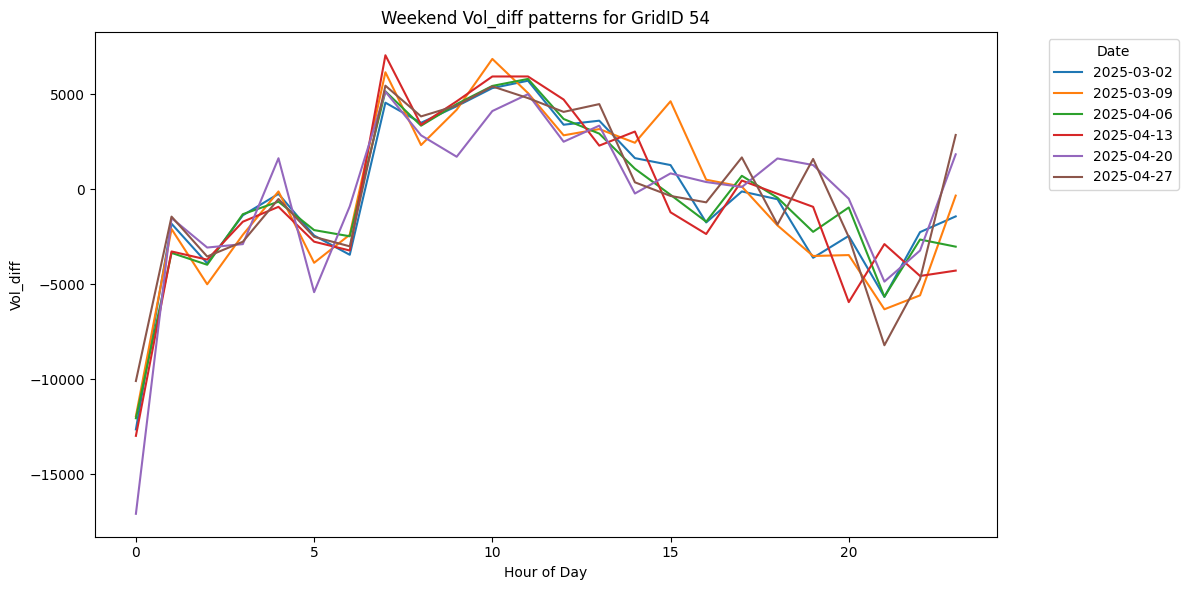

In [ ]:

df_sun['date'] = df_sun['End_Time'].dt.date
df_sun['hour'] = df_sun['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_sun.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekend Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [43]:
integrals_sun = {}

for date, group in df_sun.groupby('date'):
    # Make sure values are sorted in time
    group = group.sort_values('End_Time')
    
    # x = time in hours since start of the day
    x = (group['End_Time'] - group['End_Time'].min()).dt.total_seconds() / 3600
    y = group['Vol_diff'].values
    
    # Trapezoidal integration
    integral = np.trapz(y, x)
    integrals_sun[date] = integral

# Convert to DataFrame
daily_integrals_sun = pd.DataFrame(list(integrals_sun.items()), columns=['date', 'integral'])
print(daily_integrals_sun)

         date  integral
0  2025-03-02   -3072.5
1  2025-03-09   -4308.5
2  2025-04-06   -2588.0
3  2025-04-13   -4722.5
4  2025-04-20     468.0
5  2025-04-27     519.5


C:\Users\smurph61\AppData\Local\Temp\ipykernel_14308\1795947066.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(y, x)


In [45]:
def fit_fourier(df, n_harmonics=3):
    """
    Fit Fourier series to Vol_diff as a function of hour-of-day.
    Returns model and dataframe with fitted curve.
    """
    # Ensure datetime
    df['End_Time'] = pd.to_datetime(df['End_Time'])
    df['hour'] = df['End_Time'].dt.hour
    
    # Collapse by average per hour (so all days align)
    hourly = df.groupby('hour')['Vol_diff'].mean().reset_index()
    X = []
    
    for k in range(1, n_harmonics+1):
        hourly[f'sin{k}'] = np.sin(2*np.pi*k*hourly['hour']/24)
        hourly[f'cos{k}'] = np.cos(2*np.pi*k*hourly['hour']/24)
        X.append(hourly[[f'sin{k}', f'cos{k}']])
    
    X = pd.concat(X, axis=1)
    
    # Fit regression
    model = LinearRegression()
    model.fit(X, hourly['Vol_diff'])
    
    # Predict smooth curve
    hours = np.linspace(0, 23, 200)
    X_pred = []
    for k in range(1, n_harmonics+1):
        X_pred.append(pd.DataFrame({
            f'sin{k}': np.sin(2*np.pi*k*hours/24),
            f'cos{k}': np.cos(2*np.pi*k*hours/24)
        }))
    X_pred = pd.concat(X_pred, axis=1)
    y_pred = model.predict(X_pred)
    
    return hourly, hours, y_pred, model

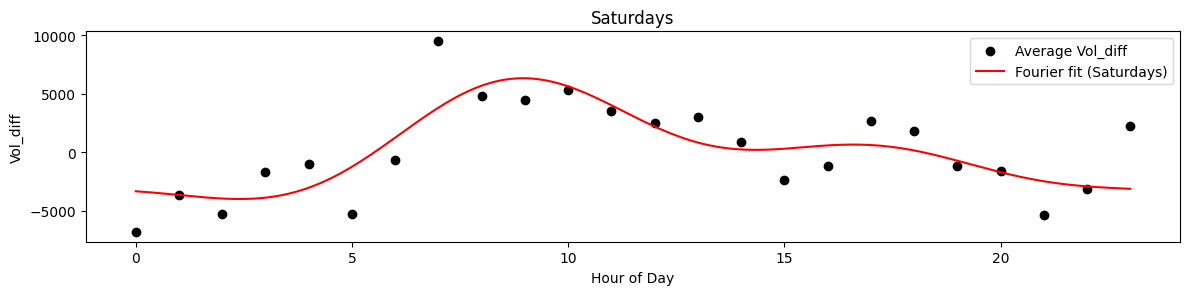

In [53]:
groups = {
    #"Weekdays": df_weekdays,
    "Saturdays": df_sat,
    # "Sundays": df_sun
}

plt.figure(figsize=(12,8))
for i, (label, df) in enumerate(groups.items(), 1):
    hourly, hours, y_pred, model = fit_fourier(df, n_harmonics=3)
    plt.subplot(3,1,i)
    plt.scatter(hourly['hour'], hourly['Vol_diff'], label="Average Vol_diff", color="black")
    plt.plot(hours, y_pred, label=f"Fourier fit ({label})", color="red")
    plt.title(label)
    plt.xlabel("Hour of Day")
    plt.ylabel("Vol_diff")
    plt.legend()

plt.tight_layout()
plt.show()

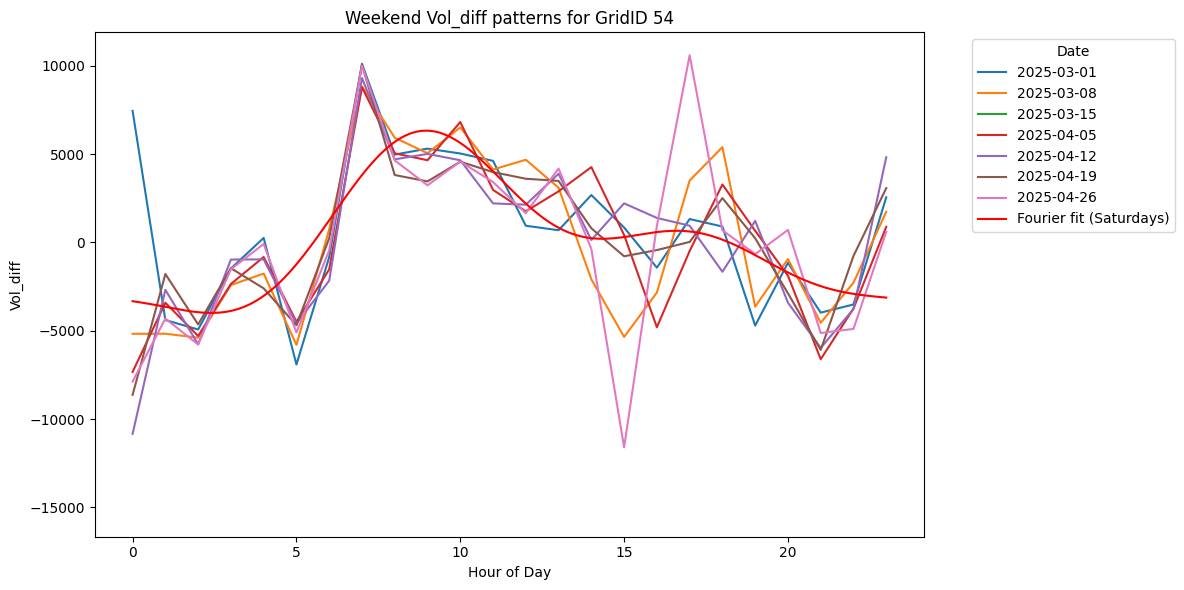

In [ ]:
df_sat['date'] = df_sat['End_Time'].dt.date
df_sat['hour'] = df_sat['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_sat.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.plot(hours, y_pred, label=f"Fourier fit ({label})", color="red")
plt.xlabel("Hour of Day")

plt.ylabel("Vol_diff")
plt.title(f"Weekend Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
#edit

C:\Users\smurph61\AppData\Local\Temp\ipykernel_14308\232727154.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_full = hourly_full.merge(hourly, on='hour', how='left').interpolate().fillna(method='bfill').fillna(method='ffill')
C:\Users\smurph61\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.330e+05, tolerance: 6.692e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\smurph61\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality g

Chosen alpha (LassoCV): 10.0


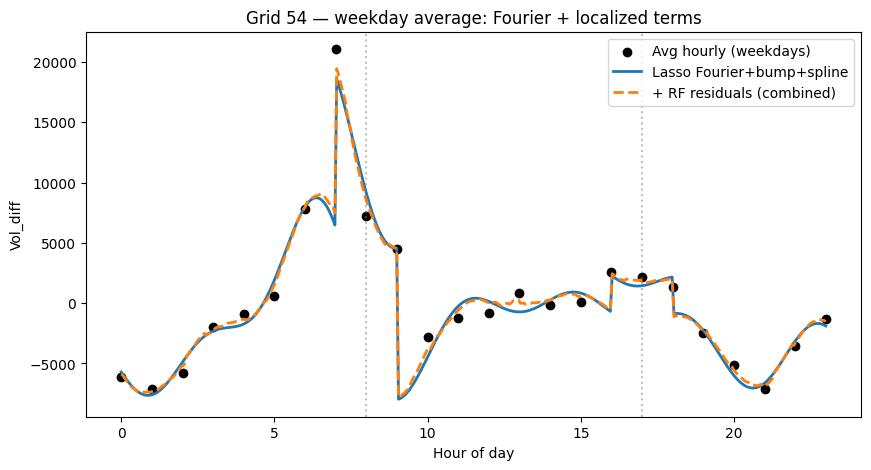

In-sample RMSE (combined): 516.8286830101424
In-sample RMSE (Lasso): 974.3643593308109


In [59]:
# PARAMETERS you can tune
grid_id = 54                     # choose grid id you want to model
n_harmonics = 6                  # number of Fourier harmonics (increase -> more detail)
gaussian_centers = [8, 17]       # hours where localized bumps can capture rush spikes
gauss_sigma = 1.1                # width of gaussian bumps (hours)
use_splines = True
spline_knots = 6                 # number of knots for spline basis
use_rf_residuals = True          # if True, fit RF on residuals and combine

# Prepare hourly average for weekdays for chosen grid
df = joined_eval.copy()
df['End_Time'] = pd.to_datetime(df['End_Time'])
df = df[df['Grid_ID'] == grid_id]
# keep only weekdays (0..4)
df_weekdays = df[df['weekday'] < 5].copy()
# create continuous hour-of-day (allow fractional if your data has minutes)
df_weekdays['hour'] = df_weekdays['End_Time'].dt.hour + df_weekdays['End_Time'].dt.minute/60.0

# Aggregate to mean Vol_diff per hour (aligning same-hour across weekdays)
hourly = df_weekdays.groupby('hour')['Vol_diff'].mean().reset_index().sort_values('hour')
# make sure we cover 0..23 even if some hours missing
all_hours = np.arange(0, 24, 1.0)   # integer-hour grid for training
hourly_full = pd.DataFrame({'hour': all_hours})
hourly_full = hourly_full.merge(hourly, on='hour', how='left').interpolate().fillna(method='bfill').fillna(method='ffill')
hours_train = hourly_full['hour'].values
y_train = hourly_full['Vol_diff'].values

# Build feature matrices
def build_fourier_features(hours, n_harmonics):
    Xf = {}
    for k in range(1, n_harmonics + 1):
        Xf[f'sin_{k}'] = np.sin(2 * np.pi * k * hours / 24.0)
        Xf[f'cos_{k}'] = np.cos(2 * np.pi * k * hours / 24.0)
    return pd.DataFrame(Xf)

def build_gaussian_bumps(hours, centers, sigma):
    Xg = {}
    for c in centers:
        Xg[f'gauss_{int(c)}'] = np.exp(-0.5 * ((hours - c) / sigma) ** 2)
    return pd.DataFrame(Xg)

def build_rush_indicators(hours):
    return pd.DataFrame({
        'rush_morning': ((hours >= 7) & (hours <= 9)).astype(float),
        'rush_evening': ((hours >= 16) & (hours <= 18)).astype(float)
    })

# Fourier features (training)
Xf_train = build_fourier_features(hours_train, n_harmonics)

# Gaussian bumps
Xg_train = build_gaussian_bumps(hours_train, gaussian_centers, gauss_sigma)

# Rush indicators
Xi_train = build_rush_indicators(hours_train)

# Splines (fit transformer on training hours)
if use_splines:
    st = SplineTransformer(n_knots=spline_knots, degree=3, include_bias=False)
    S_train = st.fit_transform(hours_train.reshape(-1, 1))
    S_train_df = pd.DataFrame(S_train, columns=[f'spline_{i}' for i in range(S_train.shape[1])])
else:
    S_train_df = pd.DataFrame(index=hours_train)

# Combine all features
X_train = pd.concat([Xf_train, Xg_train, Xi_train, S_train_df], axis=1)

# Fit LassoCV (regularized linear model)
alphas = np.logspace(-6, 1, 60)
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv.fit(X_train.values, y_train)
print("Chosen alpha (LassoCV):", lasso_cv.alpha_)

# Dense prediction grid for smooth curve
hours_dense = np.linspace(0, 23, 400)
Xf_pred = build_fourier_features(hours_dense, n_harmonics)
Xg_pred = build_gaussian_bumps(hours_dense, gaussian_centers, gauss_sigma)
Xi_pred = build_rush_indicators(hours_dense)
if use_splines:
    S_pred = st.transform(hours_dense.reshape(-1, 1))
    S_pred_df = pd.DataFrame(S_pred, columns=[f'spline_{i}' for i in range(S_pred.shape[1])])
else:
    S_pred_df = pd.DataFrame(index=hours_dense)

X_pred = pd.concat([Xf_pred, Xg_pred, Xi_pred, S_pred_df], axis=1)

# Predict with Lasso
y_pred_lasso = lasso_cv.predict(X_pred.values)

# Optionally fit RandomForest on residuals (trained on the original hourly grid)
if use_rf_residuals:
    # Compute in-sample residuals at training hours
    y_train_hat = lasso_cv.predict(X_train.values)
    resid = y_train - y_train_hat
    rf = RandomForestRegressor(n_estimators=200, random_state=0, max_depth=6)
    rf.fit(X_train.values, resid)
    resid_pred = rf.predict(X_pred.values)
    y_pred_combined = y_pred_lasso + resid_pred
else:
    y_pred_combined = y_pred_lasso

# Plot results
plt.figure(figsize=(10,5))
plt.scatter(hours_train, y_train, label='Avg hourly (weekdays)', color='k')
plt.plot(hours_dense, y_pred_lasso, label='Lasso Fourier+bump+spline', linewidth=2)
if use_rf_residuals:
    plt.plot(hours_dense, y_pred_combined, label='+ RF residuals (combined)', linewidth=2, linestyle='--')
plt.axvline(8, color='gray', linestyle=':', alpha=0.5)
plt.axvline(17, color='gray', linestyle=':', alpha=0.5)
plt.xlabel('Hour of day')
plt.ylabel('Vol_diff')
plt.title(f'Grid {grid_id} — weekday average: Fourier + localized terms')
plt.legend()
plt.show()

# Report in-sample fit statistics
# compute predictions back at training hours
if use_rf_residuals:
    y_train_combined = lasso_cv.predict(X_train.values) + rf.predict(X_train.values)
    rmse_combined = np.sqrt(mean_squared_error(y_train, y_train_combined))
    print("In-sample RMSE (combined):", rmse_combined)
rmse_lasso = np.sqrt(mean_squared_error(y_train, lasso_cv.predict(X_train.values)))
print("In-sample RMSE (Lasso):", rmse_lasso)